# Example – fltering mobile phone spam with the Naive Bayes algorithm

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
import statsmodels.api as sm

# Step 1 – collecting data

In [3]:
#To develop the Naive Bayes classifer, we will use data adapted from the SMS Spam
#Collection at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/
df = pd.read_csv('10 sms_spam.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
type    5574 non-null object
text    5574 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


# Step 2 – exploring and preparing the data

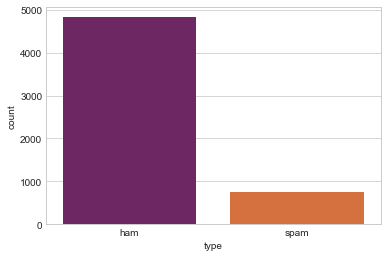

In [4]:
sns.countplot('type',data=df,palette='inferno')

In [5]:
#Data preparation – cleaning and standardizing text data
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#Lower 
#Remove numbers
#Remove punctuations
#Remove stopwords
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df['text'] = df['text'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
df['text'] = df['text'].apply(lambda x: ' '.join([i for i in x.split() if i.lower() not in stopwords.words('english')]))
df.head()

,type,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though


In [7]:
#Data preparation – splitting text documents into words
def text_process (x):
    return x.split()
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])
print(len(bow_transformer.vocabulary_))

8556


In [8]:
print(bow_transformer.get_feature_names()[0])
print(bow_transformer.get_feature_names()[8555])

aa
…thanks


In [9]:
#Data preparation – creating training and test datasets
df['length'] = df['text'].apply(lambda x: len(x))
df = df[df['length']>0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5573
Data columns (total 3 columns):
type      5568 non-null object
text      5568 non-null object
length    5568 non-null int64
dtypes: int64(1), object(2)
memory usage: 174.0+ KB


In [10]:
x_train = df[:4168]['text']
y_train = df[:4168]['type']
x_test = df[4168:]['text']
y_test = df[4168:]['type']

In [11]:
#Data preparation – creating indicator features for frequent words
messages_bow = bow_transformer.transform(x_train)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4168, 8556)


# Step 3 – training a model on the data

In [12]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, y_train)

# Step 4 – evaluating model performance

In [13]:
messages_bow = bow_transformer.transform(x_test)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(1400, 8556)


In [14]:
y_pred = spam_detect_model.predict(messages_tfidf)
print(y_pred)

['ham' 'ham' 'ham' ..., 'ham' 'ham' 'ham']


In [15]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[1218    0]
 [  51  131]]


# Step 5 – Measuring performance for classifcation

In [16]:
df_table = confusion_matrix(y_test,y_pred)
a = (df_table[0,0] + df_table[1,1]) / (df_table[0,0] + df_table[0,1] + df_table[1,0] + df_table[1,1])
p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
f = (2 * p * r) / (p + r)

print("accuracy : ",round(a,2))
print("precision: ",round(p,2))
print("recall   : ",round(r,2))
print("F1 score : ",round(f,2))

accuracy :  0.96
precision:  1.0
recall   :  0.72
F1 score :  0.84
